In [14]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for clean output

# Load the sales trends dataset
df = pd.read_excel('../data/sales_trends.xlsx')
df['date'] = pd.to_datetime(df['date'])

# Drop duplicates and sort the data
df = df.drop_duplicates(subset='date').sort_values('date')
df.set_index('date', inplace=True)

# Resample the 'income' column to daily frequency, summing up the income for each day
daily_income = df['income'].resample('D').sum()

# Fit the ARIMA model (the order p, d, q should be determined using diagnostics like ACF and PACF plots)
model = ARIMA(daily_income, order=(1, 1, 1))  # Example order, may need to be tuned
model_fit = model.fit()

# Summary of the model
model_summary = model_fit.summary()
print(model_summary)

# Forecasting future sales
forecast_steps = 30  # Forecast the next 30 days
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

# Display the forecast
print(forecast_df)

# Split the data into training and testing sets
train_data = daily_income[:-forecast_steps]
test_data = daily_income[-forecast_steps:]

# Fit the ARIMA model with the training data
model = ARIMA(train_data, order=(1, 1, 1))  # Example order, may need to be tuned
model_fit = model.fit()

# Make predictions on the test set
forecast = model_fit.get_forecast(steps=len(test_data))
y_pred = forecast.predicted_mean

# Calculate evaluation metrics
mae = mean_absolute_error(test_data, y_pred)
rmse = np.sqrt(mean_squared_error(test_data, y_pred))
mape = np.mean(np.abs((test_data - y_pred) / test_data)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)


                               SARIMAX Results                                
Dep. Variable:                 income   No. Observations:                  181
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -409.767
Date:                Wed, 13 Mar 2024   AIC                            825.534
Time:                        12:13:23   BIC                            835.113
Sample:                    01-01-2023   HQIC                           829.418
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0425      0.075     -0.565      0.572      -0.190       0.105
ma.L1         -0.9999      5.217     -0.192      0.848     -11.224       9.225
sigma2         5.3968     28.113      0.192      0.8

In [15]:
from sklearn.metrics import r2_score

# R-squared
r2 = r2_score(test_data, y_pred)
print("R-squared:", r2)

# AIC and BIC
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)

R-squared: -0.0021792020678232937
AIC: 687.4479077887602
BIC: 696.479813671049


In [16]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
best_aic = np.inf
best_pdq = None
temp_model = None

for param in pdq:
    try:
        temp_model = ARIMA(train_data, order=param)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print("Best ARIMA{} model - AIC:{}".format(best_pdq, best_aic))

# Fit the ARIMA model with the best found parameters
model = ARIMA(train_data, order=best_pdq)
model_fit = model.fit()

# Make predictions on the test set
forecast = model_fit.get_forecast(steps=len(test_data))
y_pred = forecast.predicted_mean

# Calculate evaluation metrics
mae = mean_absolute_error(test_data, y_pred)
rmse = np.sqrt(mean_squared_error(test_data, y_pred))
mape = np.mean(np.abs((test_data - y_pred) / test_data)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Best ARIMA(0, 0, 0) model - AIC:684.0307672774993
Mean Absolute Error (MAE): 2.1014890771095525
Root Mean Squared Error (RMSE): 2.415112581782226
Mean Absolute Percentage Error (MAPE): 51.12867901362614


In [17]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 4)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Define the seasonal p, d and q parameters to take any value between 0 and 2
P = D = Q = s = range(0, 3)

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(P, D, Q, s))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
best_aic = np.inf
best_pdq = best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(train_data,
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMA{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

# Fit the SARIMA model with the best found parameters
model = SARIMAX(train_data,
                order=best_pdq,
                seasonal_order=best_seasonal_pdq,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()

# Make predictions on the test set
forecast = model_fit.get_forecast(steps=len(test_data))
y_pred = forecast.predicted_mean

# Calculate evaluation metrics
mae = mean_absolute_error(test_data, y_pred)
rmse = np.sqrt(mean_squared_error(test_data, y_pred))
mape = np.mean(np.abs((test_data - y_pred) / test_data)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13281D+00    |proj g|=  1.40310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.044D-08   3.133D+00
  F =   3.1328104758707815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.17358D+00    |proj g|=  3.99493D-02

At iterate   10    f=  2.17242D+00    |proj g|=  1.54950D-02

At iterate   15    f=  2.17192D+00    |proj g|=  4.58757D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   3.910D-05   2.172D+00
  F =   2.1719225163042886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75965D+00    |proj g|=  9.60672D-06

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20184D+00    |proj g|=  1.10068D-01

At iterate    5    f=  2.17480D+00    |proj g|=  2.75058D-02

At iterate   10    f=  2.17234D+00    |proj g|=  3.66882D-02

At iterate   15    f=  2.16748D+00    |proj g|=  1.73805D-02

At iterate   20    f=  2.16728D+00    |proj g|=  1.67000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   6.564D-06   2.167D+00
  F =   2.1672810834344483     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83238D+00    |proj g|=  2.68902D-01

At iterate    5    f=  2.63348D+00    |proj g|=  5.26196D-02

At iterate   10    f=  2.62637D+00    |proj g|=  3.87953D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   5.373D-06   2.626D+00
  F =   2.6263656698653084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.36662D+00    |proj g|=  9.56641D-01

At iterate   10    f=  2.25722D+00    |proj g|=  1.61748D-01

At iterate   15    f=  2.24281D+00    |proj g|=  2.66137D+00

At iterate   20    f=  2.20108D+00    |proj g|=  1.67221D+00

At iterate   25    f=  2.19686D+00    |proj g|=  3.17725D-02

At iterate   30    f=  2.19625D+00    |proj g|=  2.05574D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     52      1     0     0   5.825D-05   2.196D+00
  F =   2.1962355368517472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69243D+00    |proj g|=  1.30639D-01

At iterate    5    f=  2.40118D+00    |proj g|=  8.47897D-02

At iterate   10    f=  2.36888D+00    |proj g|=  3.88825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.154D-06   2.369D+00
  F =   2.3688840152223327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.30612D+00    |proj g|=  4.08337D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   9.772D-07   2.306D+00
  F =   2.3061198938647673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71369D+00    |proj g|=  4.04070D-01

At iterate    5    f=  2.59288D+00    |proj g|=  3.75436D-01

At iterate   10    f=  2.30056D+00    |proj g|=  9.47872D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.24455D+00    |proj g|=  2.56105D-01

At iterate   25    f=  2.24446D+00    |proj g|=  5.38791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     88      2     0     0   5.388D-03   2.244D+00
  F =   2.2444638339104546     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30595D+00    |proj g|=  3.53290D-01

At iterate    5    f=  2.21157D+00    |proj g|=  6.22971D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89722D+00    |proj g|=  3.33075D-01

At iterate    5    f=  2.67868D+00    |proj g|=  1.71649D-01

At iterate   10    f=  2.62629D+00    |proj g|=  1.51189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   5.548D-07   2.626D+00
  F =   2.6262910445322856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.22692D+00    |proj g|=  2.48736D-02

At iterate   25    f=  2.22654D+00    |proj g|=  4.20305D-01

At iterate   30    f=  2.22629D+00    |proj g|=  6.72279D-02

At iterate   35    f=  2.22628D+00    |proj g|=  1.48262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     63      1     0     0   1.483D-03   2.226D+00
  F =   2.2262828714870930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.63898D+00    |proj g|=  4.12413D-01

At iterate   15    f=  2.51327D+00    |proj g|=  1.82283D-01

At iterate   20    f=  2.50287D+00    |proj g|=  8.78795D-02

At iterate   25    f=  2.50092D+00    |proj g|=  2.38272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   1.045D-04   2.501D+00
  F =   2.5009162816911821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   5.224D-06   2.463D+00
  F =   2.4629673889108150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57517D+00    |proj g|=  8.32938D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78705D+00    |proj g|=  2.56755D-01

At iterate    5    f=  2.57548D+00    |proj g|=  1.37495D-01

At iterate   10    f=  2.57500D+00    |proj g|=  6.99891D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     36      1     0     0   6.999D-05   2.575D+00
  F =   2.5749983359062063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.19572D+00    |proj g|=  7.42255D-02

At iterate   20    f=  2.19407D+00    |proj g|=  4.98364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   9.814D-06   2.194D+00
  F =   2.1940738700133200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22312D+00    |proj g|=  2.25078D-01

At iterate    5    f=  2.15827D+00    |proj g|=  6.20389D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11525D+00    |proj g|=  4.94549D-01

At iterate    5    f=  2.84460D+00    |proj g|=  2.36509D-01

At iterate   10    f=  2.44452D+00    |proj g|=  4.15143D-01

At iterate   15    f=  2.23733D+00    |proj g|=  2.91490D-01

At iterate   20    f=  2.21412D+00    |proj g|=  5.45379D-01

At iterate   25    f=  2.21038D+00    |proj g|=  2.54877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     44      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.25708D+00    |proj g|=  1.98594D-01

At iterate   10    f=  2.21207D+00    |proj g|=  7.49460D-01

At iterate   15    f=  2.20876D+00    |proj g|=  8.32335D-03

At iterate   20    f=  2.20874D+00    |proj g|=  1.68822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     37      1     0     0   1.816D-04   2.209D+00
  F =   2.2087353264384513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   6.117D-05   2.371D+00
  F =   2.3714040149269593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98248D+00    |proj g|=  3.33318D-01

At iterate    5    f=  2.71624D+00    |proj g|=  3.22416D-01

At iterate   10    f=  2.65147D+00    |proj g|=  1.73881D-01

At iterate   15    f=  2.64406D+00    |proj g|=  2.80414D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.53472D+00    |proj g|=  1.97234D-01

At iterate   25    f=  2.53353D+00    |proj g|=  3.47202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   1.164D-05   2.534D+00
  F =   2.5335271357465201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20877D+00    |proj g|=  6.03324D-02

At iterate    5    f=  2.20058D+00    |proj g|=  1.22892D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.19491D+00    |proj g|=  4.04974D-03

At iterate   25    f=  2.19483D+00    |proj g|=  1.85234D-02

At iterate   30    f=  2.19479D+00    |proj g|=  5.70969D-04

At iterate   35    f=  2.19479D+00    |proj g|=  2.04545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     43      1     0     0   2.883D-06   2.195D+00
  F =   2.1947928188956385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29620D+00    |proj g|=  4.56288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.871D-06   3.296D+00
  F =   3.2959296996939829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33028D+00    |proj g|=  3.34109D-01

At iterate    5    f=  3.14469D+00    |proj g|=  6.01030D-02

At iterate   10    f=  3.02028D+00    |proj g|=  5.39560D-01

At iterate   15    f=  2.97691D+00    |proj g|=  1.89115D-01

At iterate   20    f=  2.96761D+00    |proj g|=  1.42893D-01

At iterate   25    f=  2.96653D+00    |proj g|=  3.99276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     43      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.11231D+00    |proj g|=  1.03858D-01

At iterate   10    f=  3.04236D+00    |proj g|=  1.39207D-01

At iterate   15    f=  3.04090D+00    |proj g|=  7.34873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     24      1     0     0   3.893D-05   3.041D+00
  F =   3.0408994453059437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17910D+00    |proj g|=  6.17309D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57383D+00    |proj g|=  3.13608D-01

At iterate    5    f=  3.46382D+00    |proj g|=  2.78492D-01

At iterate   10    f=  3.38446D+00    |proj g|=  6.19536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     18      1     0     0   7.386D-06   3.383D+00
  F =   3.3834027677256104     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   3.307D-06   2.457D+00
  F =   2.4567653987248357     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87060D+00    |proj g|=  1.99912D-01

At iterate    5    f=  2.66940D+00    |proj g|=  2.50364D-01

At iterate   10    f=  2.66660D+00    |proj g|=  3.70588D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.54532D+00    |proj g|=  2.21947D-01

At iterate   20    f=  2.50448D+00    |proj g|=  3.73639D-02

At iterate   25    f=  2.50164D+00    |proj g|=  5.78141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   2.412D-04   2.502D+00
  F =   2.5016336145301685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56962D+00    |proj g|=  4.44356D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.67750D+00    |proj g|=  5.58473D-01

At iterate   10    f=  2.53580D+00    |proj g|=  4.58530D-02

At iterate   15    f=  2.51275D+00    |proj g|=  5.27483D-02

At iterate   20    f=  2.51246D+00    |proj g|=  7.71512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     33      1     0     0   2.104D-05   2.512D+00
  F =   2.5124556292169706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.74062D+00    |proj g|=  4.87778D-01

At iterate   15    f=  2.54872D+00    |proj g|=  4.76743D-02

At iterate   20    f=  2.52438D+00    |proj g|=  2.93882D-01

At iterate   25    f=  2.50145D+00    |proj g|=  3.99434D-02

At iterate   30    f=  2.50102D+00    |proj g|=  3.36195D-03

At iterate   35    f=  2.50102D+00    |proj g|=  1.34577D-03

At iterate   40    f=  2.50102D+00    |proj g|=  2.36781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     56      1     0     0   5.868D-05   2.501D+00
  F =   2.5010152425590948     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63558D+00    |proj g|=  3.22544D-01

At iterate    5    f=  3.28397D+00    |proj g|=  4.30875D-02

At iterate   10    f=  3.24482D+00    |proj g|=  2.69345D-01

At iterate   15    f=  3.23316D+00    |proj g|=  7.00694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   1.390D-07   3.233D+00
  F =   3.2331540465135071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.22261D+00    |proj g|=  1.45096D-01

At iterate   30    f=  2.22067D+00    |proj g|=  8.46997D-03

At iterate   35    f=  2.22065D+00    |proj g|=  1.03323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     57      1     0     0   3.999D-05   2.221D+00
  F =   2.2206486901429003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50832D+00    |proj g|=  6.65712D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  2.21807D+00    |proj g|=  3.07106D-01

At iterate   45    f=  2.21804D+00    |proj g|=  9.54465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     60      1     0     0   9.545D-04   2.218D+00
  F =   2.2180429595508486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64200D+00    |proj g|=  5.62756D-01

At iterate    5    f=  2.52367D+00    |proj g|=  3.55869D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  2.22372D+00    |proj g|=  1.02682D-01

At iterate   50    f=  2.22371D+00    |proj g|=  1.44716D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   1.447D-05   2.224D+00
  F =   2.2237122007922578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68049D+00    |proj g|=  7.16396D-01

At iterate    5    f=  2.52343D+00    |proj g|=  5.02775D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61761D+00    |proj g|=  1.51974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   2.934D-07   3.618D+00
  F =   3.6175528997187660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  3.53119D+00    |proj g|=  9.06126D-03

At iterate   50    f=  3.53064D+00    |proj g|=  1.84917D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     76      1     0     0   1.849D-02   3.531D+00
  F =   3.5306424217552568     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68379D+00    |proj g|=  5.89245D-01

At iterate    5    f=  3.51115D+00    |proj g|=  1.68773D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.59319D+00    |proj g|=  1.66685D-01

At iterate   15    f=  3.53422D+00    |proj g|=  1.00231D-01

At iterate   20    f=  3.51140D+00    |proj g|=  1.09378D-01

At iterate   25    f=  3.46956D+00    |proj g|=  2.11201D-01

At iterate   30    f=  3.46713D+00    |proj g|=  4.02968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     46      1     0     0   1.534D-05   3.467D+00
  F =   3.4671330126522117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.52874D+00    |proj g|=  1.48403D-01

At iterate   15    f=  3.49439D+00    |proj g|=  3.41954D-02

At iterate   20    f=  3.48365D+00    |proj g|=  2.31525D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   3.515D-05   3.483D+00
  F =   3.4832293943952641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71630D+00    |proj g|=  7.67864D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.98874D+00    |proj g|=  4.52852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   4.646D-06   2.989D+00
  F =   2.9887357246862716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67654D+00    |proj g|=  1.80716D+00

At iterate    5    f=  3.14750D+00    |proj g|=  2.95624D-01

At iterate   10    f=  3.03048D+00    |proj g|=  6.24566D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.00205D+00    |proj g|=  4.56146D-02

At iterate   15    f=  2.99503D+00    |proj g|=  1.79490D-02

At iterate   20    f=  2.99428D+00    |proj g|=  1.19564D-02

At iterate   25    f=  2.99395D+00    |proj g|=  3.89877D-03

At iterate   30    f=  2.99387D+00    |proj g|=  1.71052D-02

At iterate   35    f=  2.99382D+00    |proj g|=  1.10297D-03

At iterate   40    f=  2.99378D+00    |proj g|=  2.00168D-03

At iterate   45    f=  2.99374D+00    |proj g|=  2.63967D-03

At iterate   50    f=  2.99368D+00    |proj g|=  1.12989D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.07661D+00    |proj g|=  6.01957D-02

At iterate   15    f=  2.95505D+00    |proj g|=  9.31716D-02

At iterate   20    f=  2.95200D+00    |proj g|=  1.21107D-02

At iterate   25    f=  2.95056D+00    |proj g|=  6.92476D-03

At iterate   30    f=  2.95053D+00    |proj g|=  8.84208D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   8.842D-06   2.951D+00
  F =   2.9505250691580795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.96450D+00    |proj g|=  4.65470D-02

At iterate   30    f=  2.96306D+00    |proj g|=  1.35013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     55      1     0     0   9.692D-05   2.963D+00
  F =   2.9630501799423654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17046D+00    |proj g|=  3.95569D-01

At iterate    5    f=  2.98481D+00    |proj g|=  5.13798D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  2.90904D+00    |proj g|=  4.15674D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     66      1     1     0   1.085D-05   2.909D+00
  F =   2.9090382015860659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19789D+00    |proj g|=  6.28841D-01

At iterate    5    f=  3.15984D+00    |proj g|=  5.54941D-02

At iterate   10    f=  3.04917D+00    |proj g|=  2.38501D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.29574D+00    |proj g|=  3.56983D-01

At iterate   20    f=  3.28610D+00    |proj g|=  4.89053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   8.249D-07   3.286D+00
  F =   3.2861006735844489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67048D+00    |proj g|=  1.57755D-01

At iterate    5    f=  3.62733D+00    |proj g|=  2.16734D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.74351D+00    |proj g|=  3.20299D-01

At iterate   15    f=  3.71535D+00    |proj g|=  3.06586D-02

At iterate   20    f=  3.68490D+00    |proj g|=  2.98663D-01

At iterate   25    f=  3.67041D+00    |proj g|=  1.21460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     43      1     1     0   2.800D-05   3.670D+00
  F =   3.6704073358310412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52959D+00    |proj g|=  3.97390D-01

At iterate    5    f=  3.07500D+00    |proj g|=  1.00722D-01

At iterate   10    f=  2.94082D+00    |proj g|=  1.74399D-01

At iterate   15    f=  2.62533D+00    |proj g|=  2.55333D-01

At iterate   20    f=  2.59439D+00    |proj g|=  4.23224D-02

At iterate   25    f=  2.59420D+00    |proj g|=  1.09445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     39      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  2.24860D+00    |proj g|=  2.41158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     76      1     0     0   2.409D-02   2.249D+00
  F =   2.2486037705650923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95677D+00    |proj g|=  5.23363D-01

At iterate    5    f=  2.54495D+00    |proj g|=  4.68774D-01

At iterate   10    f=  2.49942D+00    |proj g|=  2.14435D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.34069D+00    |proj g|=  1.12049D-01

At iterate   15    f=  3.23176D+00    |proj g|=  3.72815D-01

At iterate   20    f=  3.21161D+00    |proj g|=  5.06512D-02

At iterate   25    f=  3.21152D+00    |proj g|=  3.77898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     45      1     0     0   3.779D-05   3.212D+00
  F =   3.2115186328002108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77446D+00    |proj g|=  4.64273D-01

At iterate    5    f=  3.30847D+00    |proj g|=  7.90667D-02

At iterate   10    f=  3.23888D+00    |proj g|=  1.17287D-01

At iterate   15    f=  3.08027D+00    |proj g|=  1.27275D-01

At iterate   20    f=  3.07618D+00    |proj g|=  5.81338D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     41      1     0     0   1.878D-05   3.076D+00
  F =   3.0760368343911133     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   1.663D-05   2.532D+00
  F =   2.5323748386185505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51383D+00    |proj g|=  2.00761D-01

At iterate    5    f=  2.49956D+00    |proj g|=  2.33970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     49      1     0     0   1.210D-03   2.244D+00
  F =   2.2442754881538152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45777D+00    |proj g|=  4.70367D-01

At iterate    5    f=  2.29411D+00    |proj g|=  2.27981D-01

At iterate   10    f=  2.24984D+00    |proj g|=  9.41646D-01

At iterate   15    f=  2.21674D+00    |proj g|=  1.61120D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.28914D+00    |proj g|=  9.56607D-01

At iterate   10    f=  2.22105D+00    |proj g|=  3.87141D+00

At iterate   15    f=  2.21522D+00    |proj g|=  1.87402D-01

At iterate   20    f=  2.21450D+00    |proj g|=  4.95563D-02

At iterate   25    f=  2.21425D+00    |proj g|=  1.66191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   2.149D-06   2.214D+00
  F =   2.2142505726572241     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73107D+00    |proj g|=  9.76648D-02

At iterate    5    f=  2.56078D+00    |proj g|=  4.85382D-02

At iterate   10    f=  2.55989D+00    |proj g|=  2.98566D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   2.986D-06   2.560D+00
  F =   2.5598928687410987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.22890D+00    |proj g|=  3.58969D-01

At iterate   20    f=  2.22817D+00    |proj g|=  1.18088D+00

At iterate   25    f=  2.21922D+00    |proj g|=  2.74991D+00

At iterate   30    f=  2.21570D+00    |proj g|=  6.21646D-01

At iterate   35    f=  2.21473D+00    |proj g|=  7.94842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     63      1     0     0   7.948D-03   2.215D+00
  F =   2.2147314370245681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64410D+00    |proj g|=  1.21284D-01

At iterate    5    f=  2.22077D+00    |proj g|=  1.67260D-01

At iterate   10    f=  2.18900D+00    |proj g|=  4.73102D-01

At iterate   15    f=  2.18868D+00    |proj g|=  3.48142D-03

At iterate   20    f=  2.18865D+00    |proj g|=  1.03846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   4.923D-03   2.189D+00
  F =   2.1886442572041838     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.33822D+00    |proj g|=  6.39990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   7.820D-06   2.338D+00
  F =   2.3382175807515679     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79182D+00    |proj g|=  5.50710D-01

At iterate    5    f=  2.57133D+00    |proj g|=  1.22280D-01

At iterate   10    f=  2.26562D+00    |proj g|=  1.80507D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     59      1     0     0   6.930D-04   2.231D+00
  F =   2.2310984079633447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31389D+00    |proj g|=  4.58047D-01

At iterate    5    f=  2.22564D+00    |proj g|=  3.77824D-01

At iterate   10    f=  2.21142D+00    |proj g|=  6.73017D-02

At iterate   15    f=  2.20670D+00    |proj g|=  1.63154D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.14764D+00    |proj g|=  3.33847D-03

At iterate   20    f=  2.14751D+00    |proj g|=  3.86763D-03

At iterate   25    f=  2.14750D+00    |proj g|=  4.49473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   1.628D-05   2.147D+00
  F =   2.1474996576236967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72765D+00    |proj g|=  9.81064D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  2.19355D+00    |proj g|=  6.93570D-01

At iterate   30    f=  2.19014D+00    |proj g|=  1.49755D-01

At iterate   35    f=  2.19008D+00    |proj g|=  8.84921D-03

At iterate   40    f=  2.18994D+00    |proj g|=  2.42829D-01

At iterate   45    f=  2.18915D+00    |proj g|=  9.30984D-02

At iterate   50    f=  2.18906D+00    |proj g|=  8.52941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     79      1     0     0   8.529D-03   2.189D+00
  F =   2.1890595900461163     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.32442D+00    |proj g|=  3.14852D+00

At iterate   10    f=  2.26163D+00    |proj g|=  4.06433D-01

At iterate   15    f=  2.26010D+00    |proj g|=  8.42195D-01

At iterate   20    f=  2.23730D+00    |proj g|=  2.91632D+00

At iterate   25    f=  2.22696D+00    |proj g|=  8.00523D-02

At iterate   30    f=  2.22691D+00    |proj g|=  5.00954D-01

At iterate   35    f=  2.22635D+00    |proj g|=  1.43288D-01

At iterate   40    f=  2.22630D+00    |proj g|=  6.79295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     65      1     0     0   1.610D-04   2.226D+00
  F =   2.22629443761

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.18980D+00    |proj g|=  6.59122D-02

At iterate   10    f=  2.17127D+00    |proj g|=  1.20032D-02

At iterate   15    f=  2.16971D+00    |proj g|=  6.03124D-02

At iterate   20    f=  2.16873D+00    |proj g|=  1.25505D-02

At iterate   25    f=  2.16872D+00    |proj g|=  2.43670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   2.466D-05   2.169D+00
  F =   2.1687151880400481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.52226D+00    |proj g|=  2.77940D-02

At iterate   20    f=  2.48885D+00    |proj g|=  1.86611D-01

At iterate   25    f=  2.45664D+00    |proj g|=  2.61595D-01

At iterate   30    f=  2.40682D+00    |proj g|=  1.45825D-01

At iterate   35    f=  2.40477D+00    |proj g|=  4.98010D-02

At iterate   40    f=  2.40439D+00    |proj g|=  1.29960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     80      1     0     0   1.300D-02   2.404D+00
  F =   2.4043850346517694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f=  2.19497D+00    |proj g|=  2.56687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   2.567D-02   2.195D+00
  F =   2.1949737284275543     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37484D+00    |proj g|=  4.76057D-01

At iterate    5    f=  2.18643D+00    |proj g|=  1.85413D-01

At iterate   10    f=  2.16910D+00    |proj g|=  8.52029D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.20033D+00    |proj g|=  1.10678D-01

At iterate   10    f=  2.18260D+00    |proj g|=  4.83457D-03

At iterate   15    f=  2.18259D+00    |proj g|=  1.87934D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   1.879D-06   2.183D+00
  F =   2.1825943780685728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87749D+00    |proj g|=  5.00329D-06

       

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.17494D+00    |proj g|=  2.32931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     29      1     0     0   4.991D-05   2.175D+00
  F =   2.1749356624231906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64872D+00    |proj g|=  1.06875D-01

At iterate    5    f=  2.57873D+00    |proj g|=  6.27835D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.18004D+00    |proj g|=  9.87380D-02

At iterate   15    f=  2.17903D+00    |proj g|=  2.18217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   1.301D-06   2.179D+00
  F =   2.1790297490378712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35300D+00    |proj g|=  2.45039D-01

At iterate    5    f=  2.21767D+00    |proj g|=  1.48214D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.76412D+00    |proj g|=  1.71749D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   4.968D-06   2.764D+00
  F =   2.7639632270997958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96308D+00    |proj g|=  8.38436D-02

At iterate    5    f=  2.56932D+00    |proj g|=  4.03096D-01

At iterate   10    f=  2.44493D+00    |proj g|=  3.77003D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   3.098D-05   2.152D+00
  F =   2.1524182685654520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77222D+00    |proj g|=  2.82763D-01

At iterate    5    f=  2.61501D+00    |proj g|=  2.14853D-01

At iterate   10    f=  2.57653D+00    |proj g|=  7.25437D-02

At iterate   15    f=  2.57422D+00    |proj g|=  7.70966D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.21199D+00    |proj g|=  2.76100D-02

At iterate   25    f=  2.21049D+00    |proj g|=  6.25885D-02

At iterate   30    f=  2.21044D+00    |proj g|=  4.41239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     52      1     0     0   3.106D-04   2.210D+00
  F =   2.2104423005003753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26262D+00    |proj g|=  2.93544D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.17965D+00    |proj g|=  1.01500D-02

At iterate   20    f=  2.17952D+00    |proj g|=  2.33588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   1.544D-05   2.180D+00
  F =   2.1795183729844609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07521D+00    |proj g|=  8.62271D-02

At iterate    5    f=  2.93058D+00    |proj g|=  1.91613D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22975D+00    |proj g|=  2.86957D-01

At iterate    5    f=  2.18575D+00    |proj g|=  9.23605D-02

At iterate   10    f=  2.18006D+00    |proj g|=  2.93296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   2.406D-05   2.180D+00
  F =   2.1800598146031400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     64      1     0     0   3.413D-04   2.193D+00
  F =   2.1929120792117844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47769D+00    |proj g|=  1.21628D-01

At iterate    5    f=  2.24618D+00    |proj g|=  3.85448D-01

At iterate   10    f=  2.18045D+00    |proj g|=  1.31429D-02

At iterate   15    f=  2.17999D+00    |proj g|=  2.44357D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.87352D+00    |proj g|=  9.33570D-02

At iterate   10    f=  2.60756D+00    |proj g|=  3.63998D-01

At iterate   15    f=  2.29023D+00    |proj g|=  2.07961D-01

At iterate   20    f=  2.27938D+00    |proj g|=  9.65259D-02

At iterate   25    f=  2.22927D+00    |proj g|=  8.03904D-01

At iterate   30    f=  2.21028D+00    |proj g|=  3.24380D-01

At iterate   35    f=  2.20997D+00    |proj g|=  1.29923D-02

At iterate   40    f=  2.20985D+00    |proj g|=  3.41594D-03

At iterate   45    f=  2.20985D+00    |proj g|=  1.31643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     72   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24987D+00    |proj g|=  1.84095D-01

At iterate    5    f=  2.20284D+00    |proj g|=  3.56551D-02

At iterate   10    f=  2.20055D+00    |proj g|=  1.53569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   3.556D-06   2.201D+00
  F =   2.2005533787457741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.45716D+00    |proj g|=  1.07717D-01

At iterate   15    f=  2.44477D+00    |proj g|=  9.95845D-03

At iterate   20    f=  2.44475D+00    |proj g|=  2.77837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   2.778D-05   2.445D+00
  F =   2.4447450509751509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20904D+00    |proj g|=  1.65340D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.56340D+00    |proj g|=  3.93019D-01

At iterate   20    f=  2.53426D+00    |proj g|=  2.49135D-01

At iterate   25    f=  2.53273D+00    |proj g|=  3.96260D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     40      1     0     0   4.419D-05   2.533D+00
  F =   2.5327286505766895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20725D+00    |proj g|=  1.66293D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.32861D+00    |proj g|=  1.06875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     37      1     0     0   6.303D-04   2.329D+00
  F =   2.3286096641849912     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81115D+00    |proj g|=  8.25593D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.79834D+00    |proj g|=  3.98775D-01

At iterate   20    f=  2.74682D+00    |proj g|=  7.83784D-01

At iterate   25    f=  2.74494D+00    |proj g|=  1.87902D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     47      1     0     0   9.468D-06   2.745D+00
  F =   2.7449351153571171     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83965D+00    |proj g|=  5.51053D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.30262D+00    |proj g|=  1.00025D-01

At iterate   10    f=  2.93319D+00    |proj g|=  2.13963D-01

At iterate   15    f=  2.91115D+00    |proj g|=  3.93215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   2.741D-06   2.911D+00
  F =   2.9111465320478036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55083D+00    |proj g|=  3.69788D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.50786D+00    |proj g|=  7.04317D-02

At iterate   15    f=  2.48381D+00    |proj g|=  4.84499D-02

At iterate   20    f=  2.48342D+00    |proj g|=  8.04863D-03

At iterate   25    f=  2.48323D+00    |proj g|=  5.62233D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   2.199D-05   2.483D+00
  F =   2.4832262864229637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   1.586D-05   3.095D+00
  F =   3.0948154099086951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34715D+00    |proj g|=  1.15148D-01

At iterate    5    f=  3.20899D+00    |proj g|=  1.64218D-01

At iterate   10    f=  2.83215D+00    |proj g|=  2.52502D-01

At iterate   15    f=  2.77256D+00    |proj g|=  1.40336D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.34444D+00    |proj g|=  5.14834D-01

At iterate   10    f=  2.21827D+00    |proj g|=  1.73619D-01

At iterate   15    f=  2.18357D+00    |proj g|=  4.49137D-02

At iterate   20    f=  2.18191D+00    |proj g|=  1.77267D-03

At iterate   25    f=  2.18191D+00    |proj g|=  1.68556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   1.381D-06   2.182D+00
  F =   2.1819058575294625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35844D+00    |proj g|=  6.96395D-01

At iterate    5    f=  3.25896D+00    |proj g|=  6.64527D-02

At iterate   10    f=  3.05958D+00    |proj g|=  3.32535D-01

At iterate   15    f=  2.81850D+00    |proj g|=  9.54944D-02

At iterate   20    f=  2.81710D+00    |proj g|=  1.26493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   8.366D-06   2.817D+00
  F =   2.8170989751837778     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  2.20933D+00    |proj g|=  1.66277D-01

At iterate   15    f=  2.17627D+00    |proj g|=  2.88965D-02

At iterate   20    f=  2.17518D+00    |proj g|=  6.84151D-03

At iterate   25    f=  2.17466D+00    |proj g|=  6.85519D-03

At iterate   30    f=  2.17461D+00    |proj g|=  1.58730D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     37      1     0     0   1.587D-05   2.175D+00
  F =   2.1746074859589042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.29565D+00    |proj g|=  6.14987D-02

At iterate   10    f=  2.99121D+00    |proj g|=  4.51039D-01

At iterate   15    f=  2.96823D+00    |proj g|=  5.23302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   7.961D-07   2.968D+00
  F =   2.9682264435521968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29367D+00    |proj g|=  9.76219D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     80      2     0     0   3.967D-05   2.318D+00
  F =   2.3184391659128467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45570D+00    |proj g|=  2.98864D-01

At iterate    5    f=  2.30302D+00    |proj g|=  2.31458D-01

At iterate   10    f=  2.25670D+00    |proj g|=  6.37577D-02

At iterate   15    f=  2.25592D+00    |proj g|=  3.78197D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  2.20513D+00    |proj g|=  2.51612D-03

At iterate   50    f=  2.20513D+00    |proj g|=  5.90277D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   5.903D-05   2.205D+00
  F =   2.2051341474578496     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27966D+00    |proj g|=  1.10747D-01

At iterate    5    f=  3.21087D+00    |proj g|=  7.18790D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.67639D+00    |proj g|=  1.07156D+00

At iterate   15    f=  2.44256D+00    |proj g|=  6.80542D-01

At iterate   20    f=  2.32442D+00    |proj g|=  1.65779D-01

At iterate   25    f=  2.31207D+00    |proj g|=  5.89243D-02

At iterate   30    f=  2.31050D+00    |proj g|=  3.50444D-03

At iterate   35    f=  2.31050D+00    |proj g|=  2.20957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     58      1     0     0   2.210D-05   2.310D+00
  F =   2.3104982070917948     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48105D+00    |proj g|=  3.22778D-01

At iterate    5    f=  3.21686D+00    |proj g|=  5.54710D-02

At iterate   10    f=  3.19915D+00    |proj g|=  1.99166D-01

At iterate   15    f=  3.17826D+00    |proj g|=  1.22977D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   1.019D-06   3.178D+00
  F =   3.1782388634498919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.61314D+00    |proj g|=  7.71601D-02

At iterate   10    f=  2.48236D+00    |proj g|=  2.32038D-01

At iterate   15    f=  2.41768D+00    |proj g|=  8.58879D-02

At iterate   20    f=  2.36836D+00    |proj g|=  4.84215D+00

At iterate   25    f=  2.34634D+00    |proj g|=  3.68986D-01

At iterate   30    f=  2.32516D+00    |proj g|=  1.79629D+00

At iterate   35    f=  2.31133D+00    |proj g|=  2.80236D-01

At iterate   40    f=  2.31107D+00    |proj g|=  1.10849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     66      1     0     0   5.650D-04   2.311D+00
  F =   2.31106542239

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.21283D+00    |proj g|=  8.07711D-02

At iterate   35    f=  2.20798D+00    |proj g|=  9.11400D-01

At iterate   40    f=  2.20672D+00    |proj g|=  1.19046D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     63      1     0     0   2.188D-05   2.207D+00
  F =   2.2067125063231505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42306D+00    |proj g|=  5.64738D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     40      1     0     0   1.025D-04   2.808D+00
  F =   2.8078321045963373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44967D+00    |proj g|=  6.13844D-01

At iterate    5    f=  2.29450D+00    |proj g|=  2.62341D-01

At iterate   10    f=  2.24104D+00    |proj g|=  2.56890D-01

At iterate   15    f=  2.21410D+00    |proj g|=  1.95828D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.57283D+00    |proj g|=  5.98381D-02

At iterate   25    f=  2.57247D+00    |proj g|=  5.21818D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     41      1     0     0   2.880D-05   2.572D+00
  F =   2.5724662968456466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42913D+00    |proj g|=  5.77841D-01

At iterate    5    f=  2.28976D+00    |proj g|=  3.63868D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.32989D+00    |proj g|=  4.35631D-02

At iterate   15    f=  3.27072D+00    |proj g|=  1.43784D-01

At iterate   20    f=  3.23814D+00    |proj g|=  3.69232D-02

At iterate   25    f=  3.22574D+00    |proj g|=  1.35037D-01

At iterate   30    f=  3.21763D+00    |proj g|=  1.20924D-01

At iterate   35    f=  3.21356D+00    |proj g|=  1.92372D-02

At iterate   40    f=  3.21110D+00    |proj g|=  1.86293D-01

At iterate   45    f=  3.20933D+00    |proj g|=  2.83932D-01

At iterate   50    f=  3.20795D+00    |proj g|=  1.73604D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     68   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  3.16368D+00    |proj g|=  1.07956D-01

At iterate   40    f=  3.15718D+00    |proj g|=  8.58178D-02

At iterate   45    f=  3.15280D+00    |proj g|=  2.09307D-01

At iterate   50    f=  3.15046D+00    |proj g|=  1.91646D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70      1     0     0   1.916D-01   3.150D+00
  F =   3.1504588578886228     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.00880D+00    |proj g|=  3.29076D-01

At iterate   15    f=  2.97850D+00    |proj g|=  4.57576D-02

At iterate   20    f=  2.96863D+00    |proj g|=  2.37963D-02

At iterate   25    f=  2.96824D+00    |proj g|=  2.13207D-03

At iterate   30    f=  2.96808D+00    |proj g|=  2.21255D-03

At iterate   35    f=  2.96807D+00    |proj g|=  5.56179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     48      1     0     0   5.269D-05   2.968D+00
  F =   2.9680731515607874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   6.179D-06   3.346D+00
  F =   3.3464710486529015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26687D+00    |proj g|=  2.04844D+00

At iterate    5    f=  3.68087D+00    |proj g|=  7.40540D-02

At iterate   10    f=  3.60704D+00    |proj g|=  8.46780D-02

At iterate   15    f=  3.53315D+00    |proj g|=  2.76505D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.97102D+00    |proj g|=  2.16721D-02

At iterate   20    f=  2.96609D+00    |proj g|=  9.16639D-04

At iterate   25    f=  2.96605D+00    |proj g|=  1.38480D-02

At iterate   30    f=  2.96603D+00    |proj g|=  4.83526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     41      1     0     0   1.229D-04   2.966D+00
  F =   2.9660342208885884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.52316D+00    |proj g|=  2.58038D-02

At iterate   15    f=  3.52284D+00    |proj g|=  1.11790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   8.263D-07   3.523D+00
  F =   3.5228434018544923     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79058D+00    |proj g|=  2.68981D-01

At iterate    5    f=  3.65870D+00    |proj g|=  9.36799D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85559D+00    |proj g|=  4.40752D-01

At iterate    5    f=  2.80129D+00    |proj g|=  1.12080D-01

At iterate   10    f=  2.79733D+00    |proj g|=  1.77441D-01

At iterate   15    f=  2.79301D+00    |proj g|=  9.00819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   1.542D-06   2.793D+00
  F =   2.7930063235717237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.26367D+00    |proj g|=  5.01269D-02

At iterate   10    f=  3.21564D+00    |proj g|=  5.00573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     18      1     0     0   1.609D-05   3.216D+00
  F =   3.2156272015709941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23379D+00    |proj g|=  2.73769D-01

At iterate    5    f=  3.06110D+00    |proj g|=  1.22068D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  2.61381D+00    |proj g|=  1.21484D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   1.215D-01   2.614D+00
  F =   2.6138073473350922     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26051D+00    |proj g|=  1.05819D+00

At iterate    5    f=  2.79827D+00    |proj g|=  2.81519D-01

At iterate   10    f=  2.55967D+00    |proj g|=  3.66005D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.68526D+00    |proj g|=  5.03412D-01

At iterate   15    f=  2.53857D+00    |proj g|=  2.77038D-02

At iterate   20    f=  2.53231D+00    |proj g|=  1.48839D-01

At iterate   25    f=  2.51544D+00    |proj g|=  2.15594D-01

At iterate   30    f=  2.50911D+00    |proj g|=  7.94441D-02

At iterate   35    f=  2.50877D+00    |proj g|=  1.47012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     65      1     0     0   2.296D-05   2.509D+00
  F =   2.5087721558198011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.55471D+00    |proj g|=  6.31506D-01

At iterate   10    f=  3.46445D+00    |proj g|=  1.21814D-01

At iterate   15    f=  3.24377D+00    |proj g|=  3.04162D-01

At iterate   20    f=  2.83366D+00    |proj g|=  1.88808D+00

At iterate   25    f=  2.62843D+00    |proj g|=  4.81445D-01

At iterate   30    f=  2.62199D+00    |proj g|=  2.56605D-02

At iterate   35    f=  2.62195D+00    |proj g|=  4.46897D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     48      1     0     0   1.256D-04   2.622D+00
  F =   2.6219465247398754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  2.55690D+00    |proj g|=  4.54697D-02

At iterate   50    f=  2.55476D+00    |proj g|=  6.28786D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   6.288D-02   2.555D+00
  F =   2.5547635436334035     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14663D+00    |proj g|=  5.37232D-01

At iterate    5    f=  2.60754D+00    |proj g|=  4.66481D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     36      1     0     0   5.785D-05   2.568D+00
  F =   2.5681443102060086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38760D+00    |proj g|=  4.65507D-01

At iterate    5    f=  3.05505D+00    |proj g|=  2.26223D-01

At iterate   10    f=  2.93483D+00    |proj g|=  8.80940D-02

At iterate   15    f=  2.74685D+00    |proj g|=  4.03489D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.55336D+00    |proj g|=  4.50571D-02

At iterate   10    f=  3.44311D+00    |proj g|=  1.25911D-01

At iterate   15    f=  2.98745D+00    |proj g|=  5.44857D-01

At iterate   20    f=  2.80006D+00    |proj g|=  1.38654D-01

At iterate   25    f=  2.79244D+00    |proj g|=  1.89346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     36      1     0     0   1.932D-05   2.792D+00
  F =   2.7924424941082071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.43090D+00    |proj g|=  1.55269D-01

At iterate   20    f=  2.42978D+00    |proj g|=  1.62486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     0     0   9.670D-06   2.430D+00
  F =   2.4297811453671305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86995D+00    |proj g|=  6.22509D-01

At iterate    5    f=  2.67975D+00    |proj g|=  5.31468D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  2.46663D+00    |proj g|=  4.83301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     57      1     0     0   3.625D-05   2.467D+00
  F =   2.4666259364537666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91545D+00    |proj g|=  3.16705D-01

At iterate    5    f=  3.46399D+00    |proj g|=  4.47790D-02

At iterate   10    f=  3.42472D+00    |proj g|=  1.35078D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.40746D+00    |proj g|=  9.46555D-02

At iterate   30    f=  2.30510D+00    |proj g|=  2.35576D+00

At iterate   35    f=  2.25187D+00    |proj g|=  6.42123D+00

At iterate   40    f=  2.24903D+00    |proj g|=  5.36322D+00

At iterate   45    f=  2.24804D+00    |proj g|=  2.69231D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     78      1     0     0   2.692D-01   2.248D+00
  F =   2.2480360511233037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.36519D+00    |proj g|=  2.80451D-01

At iterate   20    f=  2.31650D+00    |proj g|=  2.76084D-01

At iterate   25    f=  2.31361D+00    |proj g|=  1.56096D-01

At iterate   30    f=  2.30891D+00    |proj g|=  4.61030D-01

At iterate   35    f=  2.26771D+00    |proj g|=  1.68134D+01

At iterate   40    f=  2.26215D+00    |proj g|=  1.06580D+01

At iterate   45    f=  2.25818D+00    |proj g|=  3.87482D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     94      1     0     0   5.145D-01   2.258D+00
  F =   2.2581314970291411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.22862D+00    |proj g|=  6.03722D-02

At iterate   10    f=  3.19342D+00    |proj g|=  8.17269D-02

At iterate   15    f=  2.95543D+00    |proj g|=  2.37626D-01

At iterate   20    f=  2.89889D+00    |proj g|=  3.52880D-02

At iterate   25    f=  2.89866D+00    |proj g|=  7.05573D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     42      1     0     0   7.056D-06   2.899D+00
  F =   2.8986616664770715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.56670D+00    |proj g|=  9.33737D-01

At iterate   25    f=  2.55881D+00    |proj g|=  1.52764D-02

At iterate   30    f=  2.55880D+00    |proj g|=  5.93563D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     45      1     0     0   2.424D-05   2.559D+00
  F =   2.5587989546577941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58317D+00    |proj g|=  5.18904D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.20849D+00    |proj g|=  8.05895D-01

At iterate   15    f=  2.19955D+00    |proj g|=  6.64301D-02

At iterate   20    f=  2.19777D+00    |proj g|=  1.18232D-01

At iterate   25    f=  2.19683D+00    |proj g|=  2.27927D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     46      1     0     0   1.996D-05   2.197D+00
  F =   2.1968303941788223     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.26479D+00    |proj g|=  1.34895D+00

At iterate   10    f=  2.24834D+00    |proj g|=  1.10216D+00

At iterate   15    f=  2.24511D+00    |proj g|=  7.03383D-02

At iterate   20    f=  2.24455D+00    |proj g|=  5.88388D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   3.003D-06   2.245D+00
  F =   2.2445106717343939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.19344D+00    |proj g|=  8.14081D-03

At iterate   20    f=  2.19332D+00    |proj g|=  1.98415D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     33      1     0     0   8.895D-07   2.193D+00
  F =   2.1933244929690723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28722D+00    |proj g|=  3.54189D-01

At iterate    5    f=  2.15011D+00    |proj g|=  4.24538D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.24777D+00    |proj g|=  8.73536D-01

At iterate   10    f=  2.23539D+00    |proj g|=  1.45670D-01

At iterate   15    f=  2.22694D+00    |proj g|=  5.55291D-02

At iterate   20    f=  2.22403D+00    |proj g|=  1.51175D+00

At iterate   25    f=  2.22051D+00    |proj g|=  5.27196D-02

At iterate   30    f=  2.21757D+00    |proj g|=  5.07678D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     57      1     0     0   3.636D-03   2.217D+00
  F =   2.2170506558517600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.18410D+00    |proj g|=  2.48892D-02

At iterate   15    f=  2.18259D+00    |proj g|=  1.14687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   1.142D-05   2.183D+00
  F =   2.1825872747166497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59017D+00    |proj g|=  8.74807D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27928D+00    |proj g|=  2.24277D-01

At iterate    5    f=  2.22733D+00    |proj g|=  3.30535D-02

At iterate   10    f=  2.22648D+00    |proj g|=  6.17071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   5.752D-05   2.226D+00
  F =   2.2264754922563132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.17928D+00    |proj g|=  7.72269D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     47      1     0     0   3.177D-05   2.179D+00
  F =   2.1792834371994809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95951D+00    |proj g|=  7.44402D-02
  ys=-1.017E-01  -gs= 4.633E-02 BFGS update SKIPPED

At iterate    5    f=  2.79814D+00    |proj g|=  6.21097D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30734D+00    |proj g|=  8.53931D-01

At iterate    5    f=  2.20954D+00    |proj g|=  3.53374D-02

At iterate   10    f=  2.20420D+00    |proj g|=  7.02803D-02

At iterate   15    f=  2.20248D+00    |proj g|=  4.01337D-03

At iterate   20    f=  2.20248D+00    |proj g|=  9.03682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   3.658D-06   2.202D+00
  F =   2.2024823568893530     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  2.19248D+00    |proj g|=  1.91325D-01

At iterate   40    f=  2.18909D+00    |proj g|=  9.82548D-02

At iterate   45    f=  2.18829D+00    |proj g|=  1.43030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     66      1     0     0   7.739D-06   2.188D+00
  F =   2.1882917769113752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33406D+00    |proj g|=  4.43903D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68085D+00    |proj g|=  1.03461D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     14      1     0     0   1.036D-05   2.681D+00
  F =   2.6808467367135194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26036D+00    |proj g|=  1.35384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      9      1     0     0   1.307D-05   3.260D+00
  F =   3.2603613808280669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.34638D+00    |proj g|=  1.68238D-01

At iterate   10    f=  2.22362D+00    |proj g|=  3.28004D-01

At iterate   15    f=  2.18369D+00    |proj g|=  4.79860D-02

At iterate   20    f=  2.18191D+00    |proj g|=  1.30928D-03

At iterate   25    f=  2.18190D+00    |proj g|=  1.56895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   1.569D-04   2.182D+00
  F =   2.1819040051781582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.84182D+00    |proj g|=  3.32276D-01

At iterate   10    f=  2.72960D+00    |proj g|=  3.73842D-01

At iterate   15    f=  2.59055D+00    |proj g|=  2.56565D-01

At iterate   20    f=  2.57118D+00    |proj g|=  1.20607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     38      1     0     0   2.704D-05   2.571D+00
  F =   2.5711838908123146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45201D+00    |proj g|=  3.86977D-01

At iterate    5    f=  2.40560D+00    |proj g|=  8.46567D-02

At iterate   10    f=  2.38519D+00    |proj g|=  3.27144D-01

At iterate   15    f=  2.25933D+00    |proj g|=  1.82031D-01

At iterate   20    f=  2.23627D+00    |proj g|=  3.71032D-01

At iterate   25    f=  2.23520D+00    |proj g|=  2.54602D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     49      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.21273D+00    |proj g|=  3.57884D-02

At iterate   25    f=  2.20799D+00    |proj g|=  6.55237D-01

At iterate   30    f=  2.20588D+00    |proj g|=  8.09917D-03

At iterate   35    f=  2.20588D+00    |proj g|=  3.64314D-04

At iterate   40    f=  2.20588D+00    |proj g|=  1.50660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     69      1     0     0   1.287D-04   2.206D+00
  F =   2.2058762090956447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.76889D+00    |proj g|=  2.08914D-01

At iterate   35    f=  2.74645D+00    |proj g|=  2.33586D-01

At iterate   40    f=  2.73974D+00    |proj g|=  1.48503D-01

At iterate   45    f=  2.73711D+00    |proj g|=  1.48393D-01

At iterate   50    f=  2.73432D+00    |proj g|=  1.53388D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   1.534D-01   2.734D+00
  F =   2.7343179689473613     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.31763D+00    |proj g|=  9.01448D-02

At iterate   10    f=  3.16731D+00    |proj g|=  6.58772D-01

At iterate   15    f=  3.12025D+00    |proj g|=  6.71199D-01

At iterate   20    f=  3.01292D+00    |proj g|=  1.18506D-01

At iterate   25    f=  3.00987D+00    |proj g|=  3.19744D-01

At iterate   30    f=  3.00629D+00    |proj g|=  1.65944D-02

At iterate   35    f=  3.00624D+00    |proj g|=  6.93956D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     55      1     0     0   6.039D-05   3.006D+00
  F =   3.0062405942938866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.84260D+00    |proj g|=  1.02775D-01

At iterate   15    f=  2.70746D+00    |proj g|=  1.70105D-01

At iterate   20    f=  2.62600D+00    |proj g|=  8.16165D-02

At iterate   25    f=  2.56455D+00    |proj g|=  3.66250D-01

At iterate   30    f=  2.52722D+00    |proj g|=  2.01103D-01

At iterate   35    f=  2.48672D+00    |proj g|=  5.09479D-01

At iterate   40    f=  2.44610D+00    |proj g|=  1.53666D-01

At iterate   45    f=  2.43199D+00    |proj g|=  4.97494D-01

At iterate   50    f=  2.42635D+00    |proj g|=  3.01397D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.49777D+00    |proj g|=  3.48649D-01

At iterate   20    f=  2.41974D+00    |proj g|=  2.88985D-01

At iterate   25    f=  2.39739D+00    |proj g|=  1.05260D-01

At iterate   30    f=  2.39478D+00    |proj g|=  3.04301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     53      1     0     0   2.953D-05   2.395D+00
  F =   2.3947828618434834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  2.68500D+00    |proj g|=  5.93925D-01

At iterate   25    f=  2.64429D+00    |proj g|=  9.87187D-02

At iterate   30    f=  2.64402D+00    |proj g|=  6.69899D-03

At iterate   35    f=  2.64401D+00    |proj g|=  1.87884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   3.321D-04   2.644D+00
  F =   2.6440132068840190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.22914D+00    |proj g|=  3.63389D-03

At iterate   20    f=  3.22912D+00    |proj g|=  2.40227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     38      1     0     0   9.678D-06   3.229D+00
  F =   3.2291206389799156     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83334D+00    |proj g|=  4.47578D-01

At iterate    5    f=  2.53934D+00    |proj g|=  1.00331D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  2.31853D+00    |proj g|=  1.53387D+01

At iterate   45    f=  2.27037D+00    |proj g|=  1.42273D+01

At iterate   50    f=  2.26036D+00    |proj g|=  1.26429D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74      1     0     0   1.264D+01   2.260D+00
  F =   2.2603565294564660     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97328D+00    |proj g|=  4.84020D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.87943D+00    |proj g|=  1.85213D-01

At iterate   20    f=  2.84861D+00    |proj g|=  4.92999D-02

At iterate   25    f=  2.84780D+00    |proj g|=  9.66027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     40      1     0     0   1.280D-05   2.848D+00
  F =   2.8477940688901429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36888D+00    |proj g|=  2.15739D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.20872D+00    |proj g|=  5.98292D-03

At iterate   15    f=  2.20871D+00    |proj g|=  5.94528D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   3.447D-05   2.209D+00
  F =   2.2087137296499963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30621D+00    |proj g|=  3.55662D-01

At iterate    5    f=  2.17155D+00    |proj g|=  3.00926D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  2.18315D+00    |proj g|=  9.99526D-02

At iterate   35    f=  2.18212D+00    |proj g|=  9.72897D-01

At iterate   40    f=  2.18025D+00    |proj g|=  1.23468D-01

At iterate   45    f=  2.18024D+00    |proj g|=  6.11152D-02

At iterate   50    f=  2.17954D+00    |proj g|=  1.01454D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   1.015D+00   2.180D+00
  F =   2.1795376563525952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  2.14549D+00    |proj g|=  2.44518D-03

At iterate   45    f=  2.14512D+00    |proj g|=  6.23690D-03

At iterate   50    f=  2.14510D+00    |proj g|=  8.10608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   8.106D-04   2.145D+00
  F =   2.1450974116250339     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72573D+00    |proj g|=  6.04378D-02
  ys=-5.

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.18507D+00    |proj g|=  6.01127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     45      1     0     0   6.011D-04   2.185D+00
  F =   2.1850749971557391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25988D+00    |proj g|=  5.51146D-01

At iterate    5    f=  2.22662D+00    |proj g|=  3.33822D-01

At iterate   10    f=  2.22461D+00    |proj g|=  1.06713D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     25      1     0     0   1.697D-05   2.208D+00
  F =   2.2078516089345626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51505D+00    |proj g|=  3.44537D-01

At iterate    5    f=  2.37652D+00    |proj g|=  6.29929D-02

At iterate   10    f=  2.36230D+00    |proj g|=  3.71984D-02

At iterate   15    f=  2.36205D+00    |proj g|=  1.38778D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.19379D+00    |proj g|=  7.25322D-03

At iterate   15    f=  2.19374D+00    |proj g|=  9.79469D-04

At iterate   20    f=  2.19372D+00    |proj g|=  2.18033D-02

At iterate   25    f=  2.19364D+00    |proj g|=  1.77502D-03

At iterate   30    f=  2.19364D+00    |proj g|=  3.90338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     41      1     0     0   4.556D-04   2.194D+00
  F =   2.1936380732737537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.17656D+00    |proj g|=  8.61002D-03

At iterate   20    f=  2.17495D+00    |proj g|=  2.14491D-02

At iterate   25    f=  2.17484D+00    |proj g|=  3.75950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     32      1     0     0   3.759D-05   2.175D+00
  F =   2.1748425376212679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56345D+00    |proj g|=  8.88374D-06

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     42      1     0     0   3.038D-03   2.300D+00
  F =   2.2998368960801145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28826D+00    |proj g|=  1.33351D-01

At iterate    5    f=  2.23626D+00    |proj g|=  1.59185D-01

At iterate   10    f=  2.21231D+00    |proj g|=  1.58419D-02

At iterate   15    f=  2.21213D+00    |proj g|=  2.36298D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.21145D+00    |proj g|=  6.25323D-02

At iterate   15    f=  2.20818D+00    |proj g|=  2.27328D-02

At iterate   20    f=  2.20814D+00    |proj g|=  2.13185D-03

At iterate   25    f=  2.20813D+00    |proj g|=  4.86179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     38      1     0     0   5.062D-05   2.208D+00
  F =   2.2081344029990824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.30900D+00    |proj g|=  2.90715D-01

At iterate   15    f=  2.22872D+00    |proj g|=  1.41799D+00

At iterate   20    f=  2.21276D+00    |proj g|=  3.90318D-01

At iterate   25    f=  2.21097D+00    |proj g|=  4.52849D-02

At iterate   30    f=  2.21077D+00    |proj g|=  3.80174D-02

At iterate   35    f=  2.21041D+00    |proj g|=  5.22873D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     61      1     0     0   1.306D-03   2.210D+00
  F =   2.2104021639597615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.56529D+00    |proj g|=  2.50177D-02

At iterate   15    f=  2.56284D+00    |proj g|=  2.58512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   5.605D-05   2.563D+00
  F =   2.5628410759391467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21737D+00    |proj g|=  1.37324D-01

At iterate    5    f=  2.19311D+00    |proj g|=  2.29047D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.20730D+00    |proj g|=  4.43810D-02

At iterate   30    f=  2.20718D+00    |proj g|=  3.42201D-02

At iterate   35    f=  2.20713D+00    |proj g|=  4.65322D-03

At iterate   40    f=  2.20713D+00    |proj g|=  8.58844D-03

At iterate   45    f=  2.20712D+00    |proj g|=  1.87093D-03

At iterate   50    f=  2.20712D+00    |proj g|=  4.89675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   4.897D-03   2.207D+00
  F =   2.2071189713954520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.36444D+00    |proj g|=  2.30010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     42      1     0     0   2.735D-04   2.364D+00
  F =   2.3644049468156849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82566D+00    |proj g|=  1.54658D+00

At iterate    5    f=  2.46351D+00    |proj g|=  2.32407D-01

At iterate   10    f=  2.37950D+00    |proj g|=  1.30012D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f=  2.52721D+00    |proj g|=  3.82561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     66      1     0     0   3.826D-03   2.527D+00
  F =   2.5272138197085030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47323D+00    |proj g|=  3.47414D-01

At iterate    5    f=  2.31408D+00    |proj g|=  5.93877D-02

At iterate   10    f=  2.31084D+00    |proj g|=  2.75248D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.45916D+00    |proj g|=  1.87919D-01

At iterate   10    f=  2.31499D+00    |proj g|=  5.64120D-02

At iterate   15    f=  2.31438D+00    |proj g|=  1.10626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     23      1     0     0   9.314D-06   2.314D+00
  F =   2.3143841275543156     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61756D+00    |proj g|=  2.77049D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.67306D+00    |proj g|=  2.66325D-01

At iterate   15    f=  2.56543D+00    |proj g|=  3.85087D-02

At iterate   20    f=  2.56425D+00    |proj g|=  7.34809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     31      1     0     0   2.809D-05   2.564D+00
  F =   2.5642523543945561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07652D+00    |proj g|=  5.25953D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.28605D+00    |proj g|=  1.63663D+00

At iterate   25    f=  2.27442D+00    |proj g|=  3.08486D+00

At iterate   30    f=  2.24354D+00    |proj g|=  6.72302D-01

At iterate   35    f=  2.24264D+00    |proj g|=  2.09392D-01

At iterate   40    f=  2.24180D+00    |proj g|=  1.13546D+00

At iterate   45    f=  2.23501D+00    |proj g|=  7.53521D-02

At iterate   50    f=  2.23498D+00    |proj g|=  1.76731D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     77      1     0     0   1.767D-02   2.235D+00
  F =   2.2349837286176069     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.33631D+00    |proj g|=  7.89228D-02

At iterate   10    f=  2.28881D+00    |proj g|=  5.72977D-01

At iterate   15    f=  2.22847D+00    |proj g|=  3.41566D-01

At iterate   20    f=  2.20831D+00    |proj g|=  2.60625D-01

At iterate   25    f=  2.20614D+00    |proj g|=  7.64311D-01

At iterate   30    f=  2.20449D+00    |proj g|=  1.44779D-02

At iterate   35    f=  2.20449D+00    |proj g|=  2.30542D-03

At iterate   40    f=  2.20448D+00    |proj g|=  1.55861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     63      1     0     0   1.028D-04   2.204D+00
  F =   2.20448451200

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.37172D+00    |proj g|=  6.22127D-01

At iterate   15    f=  2.35906D+00    |proj g|=  5.00469D-01

At iterate   20    f=  2.33934D+00    |proj g|=  3.31154D-01

At iterate   25    f=  2.31169D+00    |proj g|=  3.56800D-01

At iterate   30    f=  2.30883D+00    |proj g|=  1.53044D-01

At iterate   35    f=  2.30832D+00    |proj g|=  4.10841D-02

At iterate   40    f=  2.30830D+00    |proj g|=  1.91060D-03

At iterate   45    f=  2.30830D+00    |proj g|=  1.49017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     69      1     0     0   5.659D-05   2.308D+00
  F =   2.30830366080

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.04707D+00    |proj g|=  1.39552D-01

At iterate   15    f=  2.95385D+00    |proj g|=  1.14211D-01

At iterate   20    f=  2.91821D+00    |proj g|=  6.76123D-02

At iterate   25    f=  2.89373D+00    |proj g|=  1.00480D-01

At iterate   30    f=  2.87736D+00    |proj g|=  7.63160D-02

At iterate   35    f=  2.86966D+00    |proj g|=  1.06249D-01

At iterate   40    f=  2.86491D+00    |proj g|=  1.21042D-01

At iterate   45    f=  2.86043D+00    |proj g|=  8.88018D-02

At iterate   50    f=  2.85931D+00    |proj g|=  1.88061D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  3.08529D+00    |proj g|=  3.55367D-02

At iterate   15    f=  3.01830D+00    |proj g|=  2.10805D-01

At iterate   20    f=  2.92113D+00    |proj g|=  7.09157D-02

At iterate   25    f=  2.87132D+00    |proj g|=  7.99624D-02

At iterate   30    f=  2.84586D+00    |proj g|=  6.21095D-02

At iterate   35    f=  2.83112D+00    |proj g|=  1.03649D-01

At iterate   40    f=  2.82205D+00    |proj g|=  2.07805D-01

At iterate   45    f=  2.81848D+00    |proj g|=  7.22419D-02

At iterate   50    f=  2.81584D+00    |proj g|=  8.16255D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.93902D+00    |proj g|=  2.11079D-01

At iterate   25    f=  2.84341D+00    |proj g|=  8.53124D-01

At iterate   30    f=  2.82260D+00    |proj g|=  8.74552D-02

At iterate   35    f=  2.82258D+00    |proj g|=  5.97374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     91      2     0     0   2.352D-03   2.823D+00
  F =   2.8225811977556283     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.60622D+00    |proj g|=  1.43478D-01

At iterate   25    f=  2.58747D+00    |proj g|=  8.11370D-02

At iterate   30    f=  2.56013D+00    |proj g|=  9.20501D-02

At iterate   35    f=  2.54394D+00    |proj g|=  1.26683D-01

At iterate   40    f=  2.53580D+00    |proj g|=  9.27849D-02

At iterate   45    f=  2.52944D+00    |proj g|=  5.55227D-02

At iterate   50    f=  2.52778D+00    |proj g|=  1.47083D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     75      1     0     0   1.471D-01   2.528D+00
  F =   2.5277785881797099     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06236D+00    |proj g|=  3.67047D-01

At iterate    5    f=  2.91548D+00    |proj g|=  3.11377D-01

At iterate   10    f=  2.83205D+00    |proj g|=  2.22044D-01

At iterate   15    f=  2.82318D+00    |proj g|=  2.54217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   2.176D-05   2.823D+00
  F =   2.8231780813821654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.53273D+00    |proj g|=  2.52311D-02

At iterate   35    f=  2.53263D+00    |proj g|=  4.52727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     50      1     0     0   4.527D-05   2.533D+00
  F =   2.5326311015643688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63537D+00    |proj g|=  4.20635D-01

At iterate    5    f=  2.57408D+00    |proj g|=  2.89698D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.85432D+00    |proj g|=  8.34658D-02

At iterate   15    f=  2.84947D+00    |proj g|=  3.24311D-02

At iterate   20    f=  2.84852D+00    |proj g|=  7.26536D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     36      1     0     0   4.052D-06   2.849D+00
  F =   2.8485192380827704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26802D+00    |proj g|=  3.47246D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.57967D+00    |proj g|=  2.13308D-01

At iterate   10    f=  2.41051D+00    |proj g|=  8.36602D-01

At iterate   15    f=  2.37434D+00    |proj g|=  1.88719D-01

At iterate   20    f=  2.36949D+00    |proj g|=  1.03976D-01

At iterate   25    f=  2.32313D+00    |proj g|=  1.11505D-01

At iterate   30    f=  2.32148D+00    |proj g|=  3.67622D-01

At iterate   35    f=  2.32099D+00    |proj g|=  2.79331D-02

At iterate   40    f=  2.31500D+00    |proj g|=  1.41870D+00

At iterate   45    f=  2.29713D+00    |proj g|=  3.46723D+00

At iterate   50    f=  2.27970D+00    |proj g|=  1.11278D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


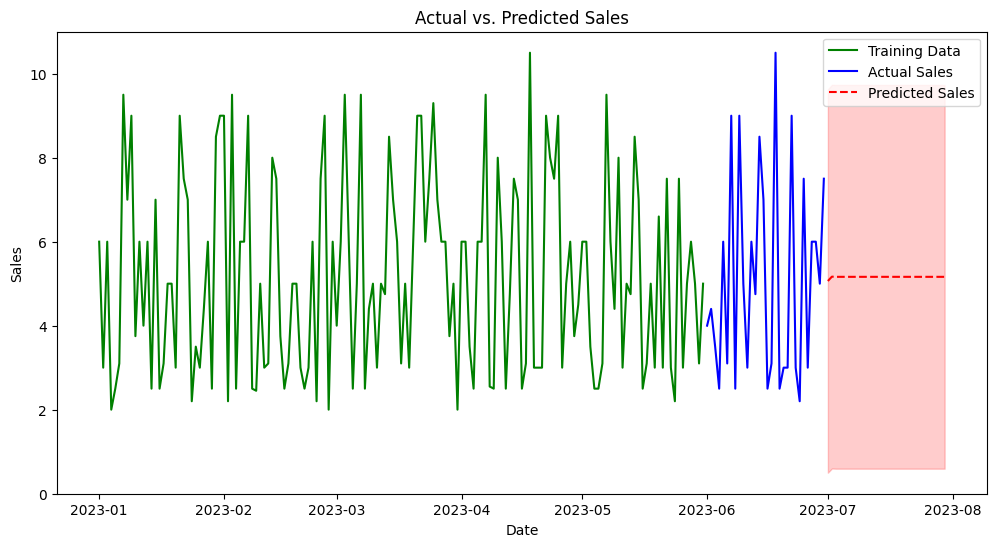

In [18]:
import matplotlib.pyplot as plt

# Assuming 'train_data', 'test_data', and 'y_pred' are as defined in your workflow

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='green')
plt.plot(test_data.index, test_data, color='blue', label='Actual Sales')
plt.plot(forecast_df.index, forecast_df['mean'], color='red', linestyle='--', label='Predicted Sales')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='red', alpha=0.2)
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
